In [30]:
import warnings

# Ignore future warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import scanpy as sc
import scvi
import scib
from tqdm import tqdm

# Set global matplotlib figure size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

# Ignore future warnings
warnings.filterwarnings("ignore")

In [31]:
outdir = "figures/integration"
os.makedirs(outdir, exist_ok=True)

In [32]:
adata = sc.read_h5ad("1_qc.h5ad")
adata

AnnData object with n_obs × n_vars = 10876 × 29965
    obs: 'sample', 'sample_type', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_lncRNA', 'log1p_total_counts_lncRNA', 'pct_counts_lncRNA', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample_group', 'facs_day'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'gene_type', 'mt', 'rRNA', 'lncRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'scrublet'
    layers: 'ambiguous', 'count', 'log1p', 'spliced', 'unspliced'

In [20]:
adata = adata[:, adata.var["gene_type"] == "rRNA"].copy()
adata

AnnData object with n_obs × n_vars = 8342 × 1
    obs: 'sample', 'sample_type', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_lncRNA', 'log1p_total_counts_lncRNA', 'pct_counts_lncRNA', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample_group', 'facs_day'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'gene_type', 'mt', 'rRNA', 'lncRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p', 'scrublet'
    layers: 'ambiguous', 'count', 'log1p', 'spliced', 'unspliced'

In [23]:
# Specify which colorings to use for plotting
umap_colorings = [
    "sample",
    "cell_type",
    "facs_day"
]

# Data preparation

In [35]:
# For now, we ignore RR cells
# They have a different gene expression profile
# Not sure how to deal with them yet (and what we want to learn from them)
adata = adata[adata.obs["sample_group"].notnull()].copy()
sample_types = adata.obs["sample_type"].unique()

type_adata = {
    sample_type: adata[adata.obs["sample_type"] == sample_type].copy()
    for sample_type in sample_types
}

type_hvg = {}

for sample_type, adata in type_adata.items():
    sc.pp.highly_variable_genes(adata, n_top_genes=5000, batch_key="sample", layer="log1p")
    type_hvg[sample_type] = adata[:, adata.var.highly_variable].copy()

## Looking at the uncorrected data distributions

In [36]:
unintegrated_dir = os.path.join(outdir, "unintegrated")
for sample_type, adata in tqdm(type_adata.items()):
    sample_dir = os.path.join(unintegrated_dir, sample_type)
    os.makedirs(sample_dir, exist_ok=True)
    sc.pp.pca(adata, n_comps=50, layer="log1p")
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    for coloring in umap_colorings:
        fig, ax = plt.subplots()
        sc.pl.umap(adata, color=coloring, title=f"Uncorrected {sample_type}", ax=ax, show=False)
        fig.tight_layout()
        fig.savefig(os.path.join(sample_dir, f"umap_{coloring}.png"))
        plt.close(fig)

100%|██████████| 3/3 [00:14<00:00,  4.67s/it]


We can see that the samples form clusters in the UMAP. This indicates that the batch effects are not negligible.
We can also see that the cell types separate in the UMAP. 
Biological signal and batch effects appear to be of similar strength in this data.

# Integration

Batch correction is referred to as integration in the single-cell literature. This is, because the count matrices are too large for performing actual batch correction. Instead, the data is integrated into a lower-dimensional space, where the batch effects are removed.

## scVI

scVI uses a variational Autoencoder to integrate the data. The encoder learns a lower-dimensional representation of the data, while the decoder learns to reconstruct the data from this representation.

In [37]:
scvi_dir = os.path.join(outdir, "scvi")
for sample_type, adata in tqdm(type_hvg.items()):
    print(f"Running scVI for {sample_type}")
    sample_dir = os.path.join(scvi_dir, sample_type)
    os.makedirs(sample_dir, exist_ok=True)
    scvi.model.SCVI.setup_anndata(adata, batch_key="sample", layer="count", categorical_covariate_keys=["facs_day"])
    model = scvi.model.SCVI(adata)
    model.train(max_epochs=400, accelerator='cpu'
                #'cuda', early_stopping=True, datasplitter_kwargs={"drop_last": True}
                )

    adata.obsm["X_scvi"] = model.get_latent_representation()

    # Plot the UMAP based on the scVI latent space
    sc.pp.neighbors(adata, use_rep="X_scvi")
    sc.tl.umap(adata)
    adata.obsm["X_umap_scvi"] = adata.obsm["X_umap"].copy()

    for coloring in umap_colorings:
        fig, ax = plt.subplots()
        sc.pl.umap(adata, color=coloring, title=f"scVI {sample_type}", ax=ax, show=False)
        fig.tight_layout()
        fig.savefig(os.path.join(sample_dir, f"umap_{coloring}.png"))
        plt.close(fig)

  0%|          | 0/3 [00:00<?, ?it/s]GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running scVI for rr_incl
Epoch 400/400: 100%|██████████| 400/400 [03:08<00:00,  2.18it/s, v_num=1, train_loss_step=2.5e+3, train_loss_epoch=1.43e+3] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:08<00:00,  2.13it/s, v_num=1, train_loss_step=2.5e+3, train_loss_epoch=1.43e+3]


 33%|███▎      | 1/3 [03:10<06:21, 190.93s/it]GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running scVI for combined
Epoch 400/400: 100%|██████████| 400/400 [04:05<00:00,  1.72it/s, v_num=1, train_loss_step=2.29e+3, train_loss_epoch=2.38e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [04:05<00:00,  1.63it/s, v_num=1, train_loss_step=2.29e+3, train_loss_epoch=2.38e+3]


 67%|██████▋   | 2/3 [07:20<03:45, 225.16s/it]GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Running scVI for rr_depl
Epoch 400/400: 100%|██████████| 400/400 [03:42<00:00,  1.83it/s, v_num=1, train_loss_step=2.35e+3, train_loss_epoch=2.26e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:42<00:00,  1.80it/s, v_num=1, train_loss_step=2.35e+3, train_loss_epoch=2.26e+3]


100%|██████████| 3/3 [11:05<00:00, 221.88s/it]


While the cell types still separate in the UMAP, the batch effects are removed. This indicates that scVI has successfully integrated the data.
However it looks overcorrected, as subpopulations are not as clearly separated as in the uncorrected data.

## Harmony

Harmony receives a PCA representation of the data and removes the batch effects from there.
Benchmarks have shown that Harmony is one of the best batch correction methods for single-cell data.

In [38]:
harmony_dir = os.path.join(outdir, "harmony")

for sample_type, adata in tqdm(type_adata.items()):
    print(f"Running Harmony for {sample_type}")
    sample_dir = os.path.join(harmony_dir, sample_type)
    os.makedirs(sample_dir, exist_ok=True)

    sc.external.pp.harmony_integrate(adata, "sample", max_iter_harmony=50)

    sc.pp.neighbors(adata, use_rep="X_pca_harmony")
    sc.tl.umap(adata)
    adata.obsm["X_umap_harmony"] = adata.obsm["X_umap"].copy()

    for coloring in umap_colorings:
        fig, ax = plt.subplots()
        sc.pl.umap(adata, color=coloring, title=f"Harmony {sample_type}", ax=ax, show=False)
        fig.tight_layout()
        fig.savefig(os.path.join(sample_dir, f"umap_{coloring}.png"))
        plt.close(fig)

  0%|          | 0/3 [00:00<?, ?it/s]2025-02-10 17:58:28,523 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony for rr_incl


2025-02-10 17:58:28,768 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-10 17:58:28,772 - harmonypy - INFO - Iteration 1 of 50
2025-02-10 17:58:28,933 - harmonypy - INFO - Iteration 2 of 50
2025-02-10 17:58:29,100 - harmonypy - INFO - Iteration 3 of 50
2025-02-10 17:58:29,274 - harmonypy - INFO - Iteration 4 of 50
2025-02-10 17:58:29,434 - harmonypy - INFO - Converged after 4 iterations
 33%|███▎      | 1/3 [00:04<00:08,  4.05s/it]2025-02-10 17:58:32,562 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony for combined


2025-02-10 17:58:32,824 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-10 17:58:32,829 - harmonypy - INFO - Iteration 1 of 50
2025-02-10 17:58:33,082 - harmonypy - INFO - Iteration 2 of 50
2025-02-10 17:58:33,305 - harmonypy - INFO - Iteration 3 of 50
2025-02-10 17:58:33,529 - harmonypy - INFO - Iteration 4 of 50
2025-02-10 17:58:33,735 - harmonypy - INFO - Iteration 5 of 50
2025-02-10 17:58:33,942 - harmonypy - INFO - Iteration 6 of 50
2025-02-10 17:58:34,140 - harmonypy - INFO - Converged after 6 iterations
 67%|██████▋   | 2/3 [00:09<00:04,  4.94s/it]2025-02-10 17:58:38,120 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


Running Harmony for rr_depl


2025-02-10 17:58:38,409 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-02-10 17:58:38,415 - harmonypy - INFO - Iteration 1 of 50
2025-02-10 17:58:38,628 - harmonypy - INFO - Iteration 2 of 50
2025-02-10 17:58:38,852 - harmonypy - INFO - Iteration 3 of 50
2025-02-10 17:58:39,071 - harmonypy - INFO - Iteration 4 of 50
2025-02-10 17:58:39,284 - harmonypy - INFO - Iteration 5 of 50
2025-02-10 17:58:39,421 - harmonypy - INFO - Iteration 6 of 50
2025-02-10 17:58:39,561 - harmonypy - INFO - Iteration 7 of 50
2025-02-10 17:58:39,694 - harmonypy - INFO - Converged after 7 iterations
100%|██████████| 3/3 [00:15<00:00,  5.02s/it]


Here, cell types also separate in the UMAP. Some samples are still clustered, but the batch effects are mostly removed.
This is probably a good compromise between removing batch effects and keeping the biological signal.

# Integration benchmarking using scIB

In [28]:
embeddings = ["X_pca", "X_pca_harmony"]

results = []

for embedding in embeddings:
    result = scib.me.metrics(adata.raw.to_adata(),
        adata,
        "sample",
        "cell_type",
        embed=embedding,
        organism='mouse',
        ari_=True,
        nmi_=True,
        silhouette_=True,
        pcr_=False,
        cell_cycle_=False,
        hvg_score_=False,
        isolated_labels_=True,
        graph_conn_=True,
        trajectory_=False,
        kBET_=False,
        lisi_graph_=True
    )

    result.columns = [embedding]
    results.append(result)

Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Isolated labels ASW...
Graph connectivity...
cLISI score...
iLISI score...
Epoch 46/400:  11%|█▏        | 45/400 [1:37:59<12:53:04, 130.66s/it, v_num=1, train_loss_step=1.39e+3, train_loss_epoch=1.56e+3]
Recompute neighbors on rep X_pca_harmony instead of X_pca
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leide

<Axes: >

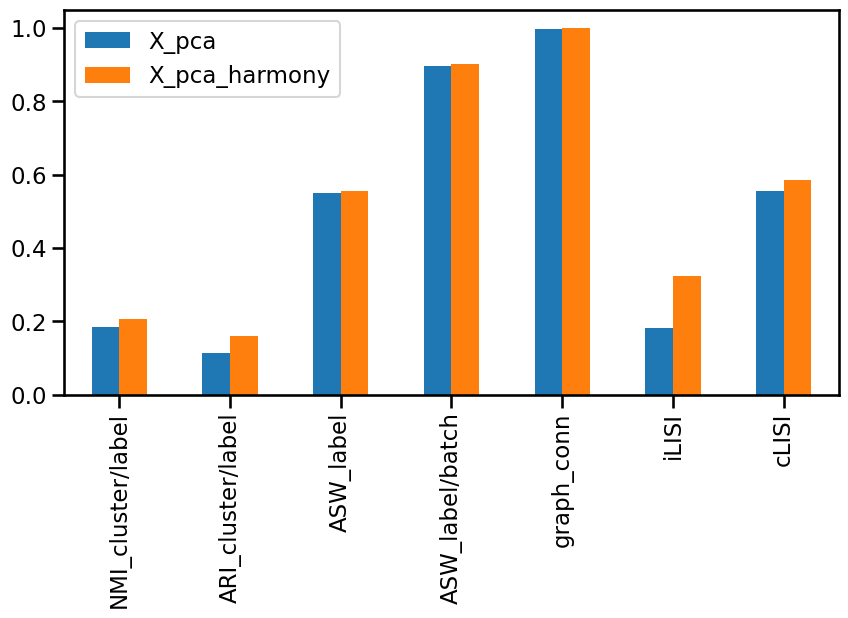

In [40]:
df_scib = pd.concat(results, axis=1)
df_scib.dropna(axis=0, how='all', inplace=True)
df_scib.plot(kind='bar', figsize=(10, 5))

# Save the data

In [26]:
adata

AnnData object with n_obs × n_vars = 2353 × 29965
    obs: 'sample', 'sample_type', 'barcode', 'well_position', 'well_row', 'well_column', 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_rRNA', 'log1p_total_counts_rRNA', 'pct_counts_rRNA', 'total_counts_lncRNA', 'log1p_total_counts_lncRNA', 'pct_counts_lncRNA', 'n_genes', 'doublet_score', 'predicted_doublet', 'sample_group', 'facs_day', 'cluster_0.2', 'cluster_0.4', 'cluster_0.6', 'cluster_0.8', 'cluster_1.0', 'cluster_1.2', 'cluster_1.4', 'cluster_1.6', 'cluster_1.8', 'cluster_2.0', 'cluster', 'silhouette_temp'
    var: 'gene_ids', 'feature_types', 'gene_symbol', 'gene_versions', 'gene_type', 'mt', 'rRNA', 'lncRNA', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_co

In [41]:
adata.write("2_integrate.h5ad")